In [1]:
import sys,os
sys.path.append("../")
from utils import *
from model import *
from loss import *
from dataset import *
from torchvision import transforms
import torch.nn as nn
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
import matplotlib.pyplot as plt
root_dir = './M10'

In [2]:
bs = 200
epochs = 20
lr = 0.001
alpha = 0.0001
save_every = 5
train_tfms = transforms.Compose([PointSampler(1024),TrainTransforms()])
test_tfms = transforms.Compose([PointSampler(1024),TestTransforms()])
train_ds = ModelNet10(root_dir = root_dir,folder='train')
test_ds = ModelNet10(root_dir = root_dir,folder = 'test')

train_dl = DataLoader(train_ds,batch_size = bs,shuffle = True)
test_dl = DataLoader(test_ds,batch_size = bs,shuffle = True)

model = PointNet(classes = len(train_ds.classes)).cuda()

optim = torch.optim.Adam(model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optim,step_size=20,gamma=0.5)
criterion = PointNetLoss(alpha=alpha)

writer = SummaryWriter('runs/experiment_1')

In [3]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for epoch in range(epochs):
    model.train()
    av_tr_loss = 0
    train_acc = 0
    
    for i,(pointclouds,labels) in enumerate(train_dl):
        optim.zero_grad()
        pointclouds = pointclouds.type(torch.FloatTensor)
        outputs,m3,m64 = model(pointclouds.cuda())
        loss = criterion(outputs,labels.cuda(),m3,m64)
        av_tr_loss += loss.item()
        acc = torch.sum(torch.argmax(outputs.cpu(),dim = 1) == labels)
        train_acc += acc
        loss.backward()
        optim.step()
        scheduler.step()
        # print("Epoch {} ,Batch {} --> Loss:{:.3f}, Accuracy:{:.2f}".format(epoch+1,(i+1),loss.item(), 100*acc.item()/labels.size()[0]))

    model.eval()
    av_test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for i,(pointclouds,labels) in enumerate(test_dl):
            pointclouds = pointclouds.type(torch.FloatTensor)
            outputs,m3,m64 = model(pointclouds.cuda())
            loss_test = criterion(outputs,labels.cuda(),m3,m64)
            av_test_loss += loss_test.item()

            test_acc += torch.sum(torch.argmax(outputs.cpu(),dim = 1) == labels)

    writer.add_scalar('Test Loss',av_test_loss/(len(test_ds)//bs),epoch)
    writer.add_scalar('Test acc',test_acc.item()/len(test_ds),epoch)
    writer.add_scalar('Train Loss',av_tr_loss/(len(train_ds)//bs),epoch)
    writer.add_scalar('Train acc',train_acc.item()/len(train_ds),epoch)
    train_losses.append(av_tr_loss/(len(train_ds)//bs))
    test_losses.append(av_test_loss/(len(test_ds)//bs))
    train_accs.append(train_acc.item()/len(train_ds))
    test_accs.append(test_acc.item()/len(test_ds))
    print("TESTING")       
    print("Epoch [{}/{}] --> Testing Loss:{:.3f}, Testing Accuracy:{:.2f}\n".format(epoch+1,epochs,av_test_loss/(len(test_ds)//bs), 100*test_acc.item()/len(test_ds)))
    print("TRAINING")
    print("Epoch [{}/{}] --> Training Loss:{:.3f}, Training Accuracy:{:.2f}\n".format(epoch+1,epochs,av_tr_loss/(len(train_ds)//bs), 100*train_acc.item()/len(train_ds)))


    if (epoch+1)%save_every == 0:
        print("SAVING MODEL CHECKPOINT")
        torch.save(model.state_dict(),'./pointnet_10_{}.pth'.format(epoch+1))
writer.flush()

TESTING
Epoch [1/20] --> Testing Loss:2.911, Testing Accuracy:21.15

TRAINING
Epoch [1/20] --> Training Loss:1.409, Training Accuracy:55.20

TESTING
Epoch [2/20] --> Testing Loss:1.459, Testing Accuracy:62.67

TRAINING
Epoch [2/20] --> Training Loss:0.731, Training Accuracy:77.75

TESTING
Epoch [3/20] --> Testing Loss:0.887, Testing Accuracy:76.32

TRAINING
Epoch [3/20] --> Training Loss:0.530, Training Accuracy:83.74

TESTING
Epoch [4/20] --> Testing Loss:0.787, Testing Accuracy:79.41

TRAINING
Epoch [4/20] --> Training Loss:0.436, Training Accuracy:87.00

TESTING
Epoch [5/20] --> Testing Loss:0.785, Testing Accuracy:78.85

TRAINING
Epoch [5/20] --> Training Loss:0.385, Training Accuracy:88.65

SAVING MODEL CHECKPOINT
TESTING
Epoch [6/20] --> Testing Loss:0.732, Testing Accuracy:79.96

TRAINING
Epoch [6/20] --> Training Loss:0.356, Training Accuracy:89.55

TESTING
Epoch [7/20] --> Testing Loss:0.733, Testing Accuracy:80.62

TRAINING
Epoch [7/20] --> Training Loss:0.344, Training Accur

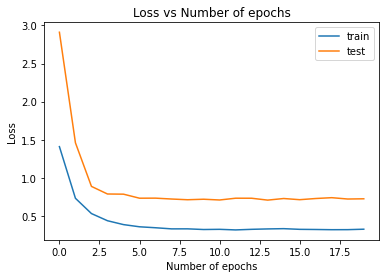

In [4]:
plt.plot(train_losses,label = 'train')
plt.plot(test_losses,label = 'test')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")
plt.show()

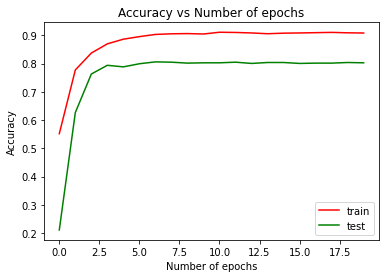

In [6]:
plt.plot(train_accs,label = 'train', color= 'red')
plt.plot(test_accs,label = 'test', color = 'green')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of epochs")
plt.show()